In [52]:
import generator

import numpy as np

import matplotlib.pyplot as plt

from skopt.plots import plot_gaussian_process
from skopt import Optimizer

In [53]:
bins_file = open('../exp_data/na49/binning.bin', 'r')

In [54]:
bins = []

for num, line in enumerate(bins_file.readlines()):

    if num % 2 == 0:
        
        a = line.split('|')

        for bin in a:

            bin = bin.replace('(', '').replace(')', '').replace(' ', '')
            bins.append(list(map(float, bin.split(','))))

bins = np.array(bins)

bins_file.close()

In [55]:
import pandas as pd

ids = [211, 321, -211, -321]

refs = {}

for id in ids:
    
    refs[id] = pd.read_csv(f'../exp_data/na49/{id}.csv')

In [56]:
inst = {
    'Print:quiet': 'on',

    'Beams:frameType': '2',

    'Beams:idA': '2212',
    'Beams:idB': '2212',

    'Beams:eA': '158',
    'Beams:eB': '0',

    'SoftQCD:all': 'on',

    'Tune:pp': '1',

    'SigmaDiffractive:dampen': 'on',
    'SpaceShower:phiIntAsym': 'on',
    'SpaceShower:phiPolAsym': 'on',
    'SpaceShower:rapidityOrder': 'on',
    'SpaceShower:rapidityOrderMPI': 'on',
    'SpaceShower:samePTasMPI': 'off',
    'TimeShower:dampenBeamRecoil': 'on',
    'TimeShower:phiPolAsym': 'on',

    'MultipartonInteractions:ecmRef': '1800',
    }

In [57]:
optim_param = 'MultipartonInteractions:ecmRef'

In [58]:
n_events = int(1e6)

def objective(x):

    new_val = x[0]

    inst[optim_param] = f'{new_val}'

    data, sigma = generator.generate(n_events, inst, bins)
    res =  generator.get_score(data, sigma, n_events, bins, refs)

    return res

In [59]:
def plot_optimizer(res, n_iter, max_iters=5):
    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False
    ax = plt.subplot(max_iters, 2, 2 * n_iter + 1)
    # Plot GP(x) + contours
    ax = plot_gaussian_process(res, ax=ax,
                               #noise_level=noise_level,
                               show_legend=show_legend, show_title=True,
                               show_next_point=False, show_acq_func=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    if n_iter < max_iters - 1:
        ax.get_xaxis().set_ticklabels([])
    # Plot EI(x)
    ax = plt.subplot(max_iters, 2, 2 * n_iter + 2)
    ax = plot_gaussian_process(res, ax=ax,
                               #noise_level=noise_level,
                               show_legend=show_legend, show_title=False,
                               show_next_point=True, show_acq_func=True,
                               show_observations=False,
                               show_mu=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    if n_iter < max_iters - 1:
        ax.get_xaxis().set_ticklabels([])

In [60]:
opt_gp = Optimizer([(1., 7000.)], base_estimator="GP", n_initial_points=1,
                acq_optimizer="sampling", random_state=42)

100%|██████████| 1000000/1000000 [02:13<00:00, 7502.15it/s]


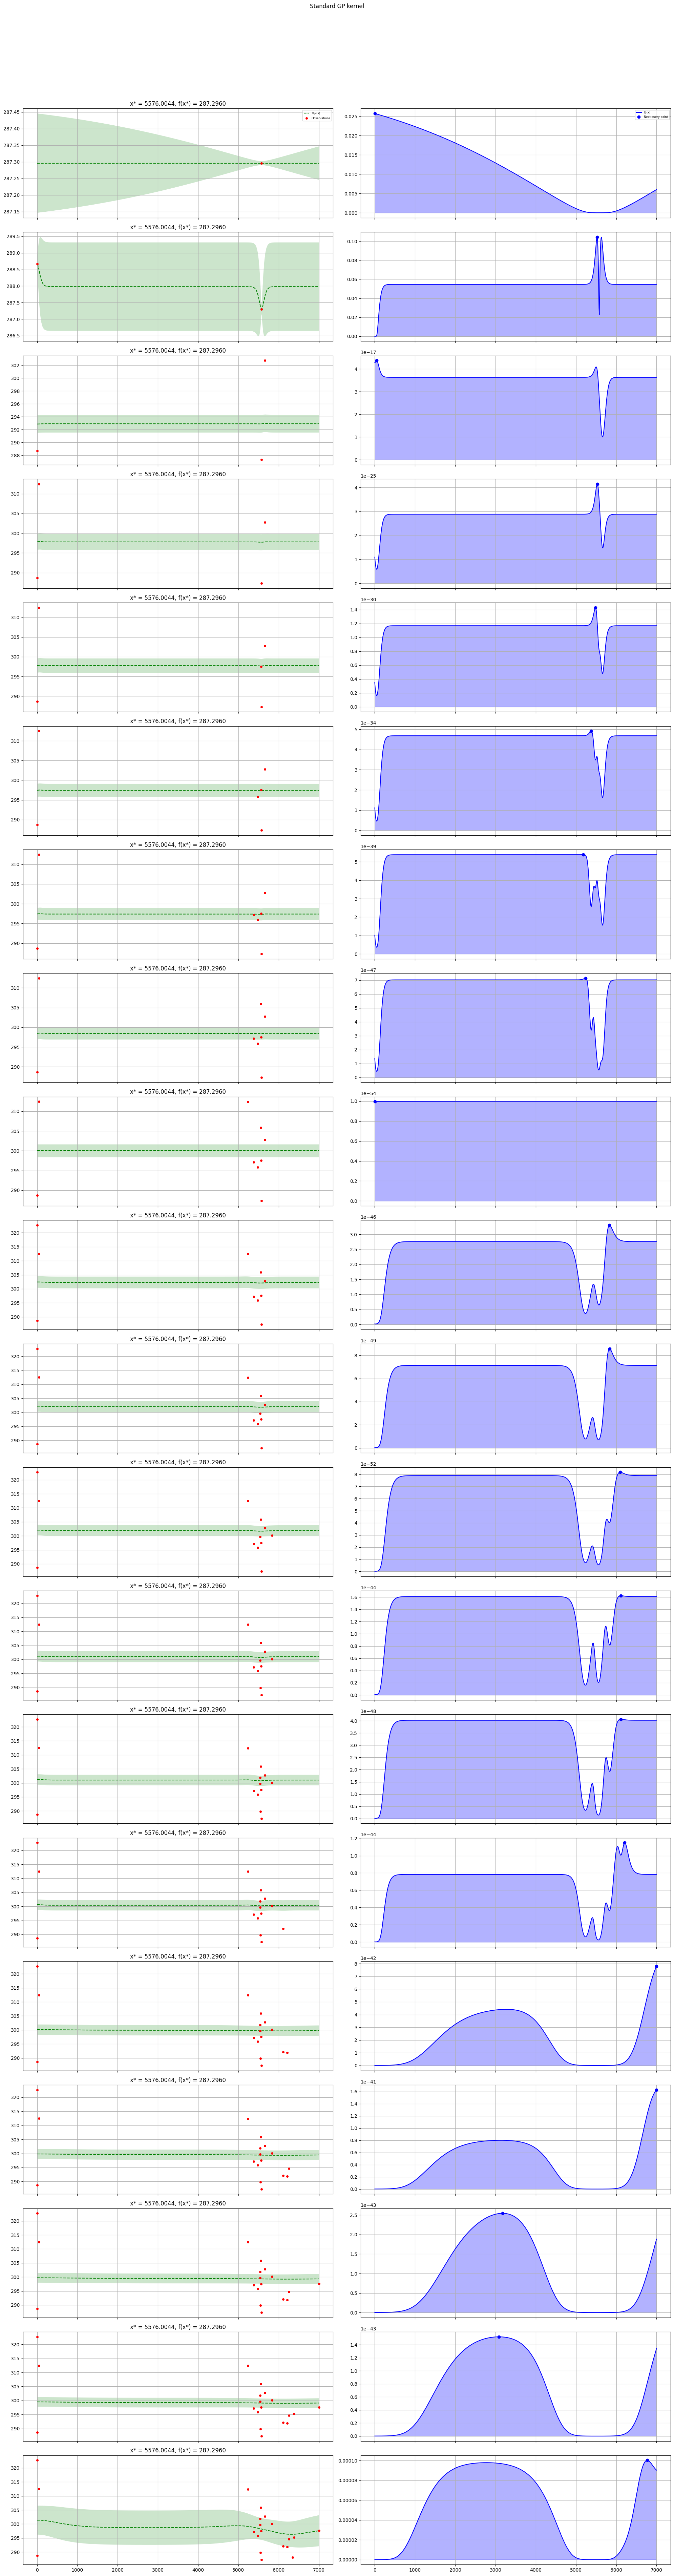

In [61]:
fig = plt.figure(figsize=(20, 80))
fig.suptitle("Standard GP kernel")

itrs = 20

for i in range(itrs):
    
    next_x = opt_gp.ask()
    f_val = objective(next_x)
    res = opt_gp.tell(next_x, f_val)
    
    plot_optimizer(res, n_iter=i, max_iters=itrs)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])